In [1]:
from IPython.display import HTML
#Instruction for hiding the code section for presentation
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [32]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import _thread as thread
%matplotlib inline 

# New York City Parking Ticket Analysis (Fiscal Year 2015 - 2017)
## Table of Contents
<ul>
    <li><a href = '#Introduction'>Introduction</a></li>
    <li><a href = '#Preparation: Initial dataset loading'>Preparation: Initial dataset loading</a></li>
    <li><a href = '#Overview - Distribution of parking tickets issued over the fiscal year.'>Data Overview - Distribution of parking tickets issued over the fiscal year.</a></li>
    <li><a href = '#Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month'>Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month</a></li>
    <li><a href = '#Total Ticket Issued on Different Hours of the Day'>Total Ticket Issued on Different Hours of the Day</a></li>
    <li><a href = '#Tickets Issued for Different Plate Types'>Tickets Issued for Different Plate Types</a></li>
    <li><a href = '#violation code with Plate Types'>violation code with Plate Types</a></li>
    <li><a href = '#Plate Type = PAS, Violation Code = 21'>Plate Type = PAS, Violation Code = 21</a></li>
    <li><a href = '#Total Tickets Issued by Each Precinct of NYC '>Total Tickets Issued by Each Precinct of NYC </a>
    <li><a href = '#References and Additonal Resources'>References and Additonal Resources</a></li>
<ul>

<a id = 'Introduction'></a>
## Introduction

<a id = 'Preparation: Initial dataset loading'></a>
## Preparation: Preparation: Initial dataset loading


Dataset Desciption: The NYC Department of Finance collects data on every parking ticket issued in NYC (~10M per year!). This data is made publicly available to aid in ticket resolution and to guide policymakers. There are three csv files (~2.1GB each), covering Aug 2014-June 2017. The files are roughly organized by fiscal year (July 1 - June 30) with the exception of the initial dataset.Columns include information about the vehicle ticketed, the ticket issued, location, and time. 

Original Dataset can be assessed through the following links:
1. Parking Violations Issued - Fiscal Year 2015 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2015/c284-tqph)
2. Parking Violations Issued - Fiscal Year 2016 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2016/kiv2-tbus)
3. Parking Violations Issued - Fiscal Year 2017 (https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2017/2bnn-yakx)

In [6]:
#Load Dataset from Fiscal Year 2015, 2016 and 2017
#This could be modified to load one single dataset, simply replace the years list with single year
#These are big files so they might take some time to load, when the loading is done, a word 'done' will be printed
years = [2015, 2016, 2017]
raw_data_15_17 = []

def loading_file(year, i):
    filename = "Parking_Violations_Issued_-_Fiscal_Year_" + str(year) + ".csv"
    print("loading data", filename, "...")
    raw_data = pd.read_csv(filename, low_memory = False)
    raw_data_15_17.append(raw_data)
    print('done!')

for year,i in zip(years, range(3)):
    loading_file(year,i)

loading data Parking_Violations_Issued_-_Fiscal_Year_2015.csv ...
done!
loading data Parking_Violations_Issued_-_Fiscal_Year_2016.csv ...
done!
loading data Parking_Violations_Issued_-_Fiscal_Year_2017.csv ...
done!


In [136]:
#NYC fiscal year starts from July to June next year
start_dates = []
end_dates = []
for year in years:
    start_dates.append(str(year-1) + "-07-01")
    end_dates.append(str(year) + "-06-30")

## 1. Overview - Distribution of parking tickets issued over the fiscal year. (2015, 2016, 2017)

Since all three datasets has been loaded into the list 'raw_data_15_17', so we can access the Parking Data from 2015 at raw_data_15_17[0]. 

Let's take a quick look to see what we have in one of the dataset :-)

In [137]:
raw_data_15_17[0].head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,8002531292,EPC5238,NY,PAS,10/01/2014,21,SUBN,CHEVR,T,20390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015318440,5298MD,NY,COM,03/06/2015,14,VAN,FRUEH,T,27790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7611181981,FYW2775,NY,PAS,07/28/2014,46,SUBN,SUBAR,T,8130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7445908067,GWE1987,NY,PAS,04/13/2015,19,4DSD,LEXUS,T,59990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7037692864,T671196C,NY,PAS,05/19/2015,19,4DSD,CHRYS,T,36090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first thing I want to do is to get a general impression regarding how the number of parking tickets distributed through out each fiscal year. For New York City, the fiscal year starts from July 1st of the previous year to June 30th of the current year. For example, fiscal year 2015 starts from July 1st,2014 and ends on June 30th, 2015.

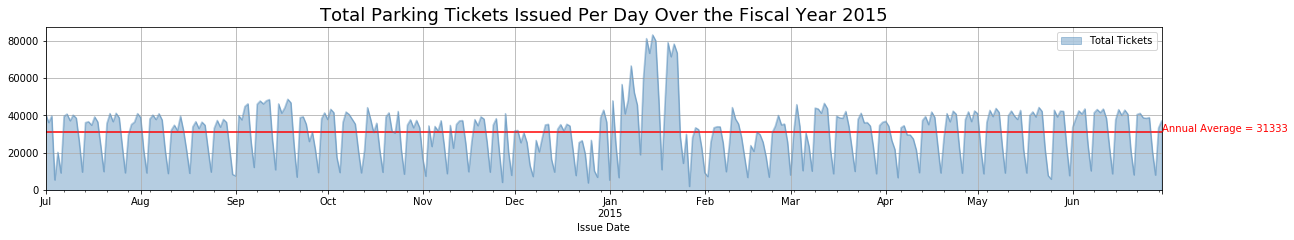

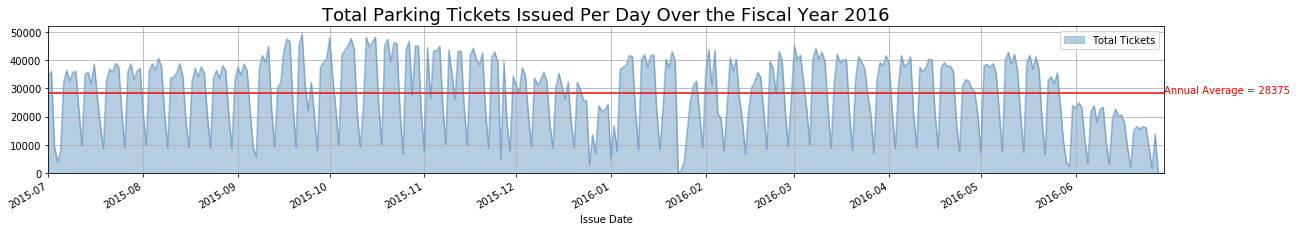

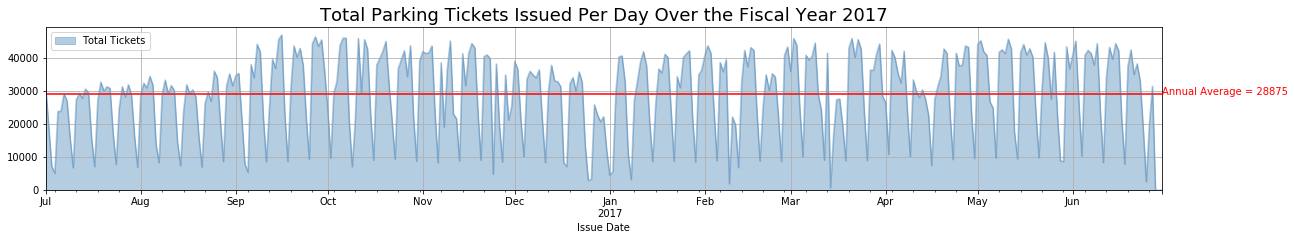

In [182]:
Date_Total_list = [] #This list will be used for the violin plots later

for raw_data, year, start_date, end_date in zip(raw_data_15_17, years, start_dates, end_dates):    
    #Data Cleaning Section
    Date_Total = raw_data[['Issue Date','Summons Number']].groupby('Issue Date', as_index = False).count() 
    Date_Total['Issue Date'] = pd.to_datetime(Date_Total['Issue Date'])
    Date_Total = Date_Total.set_index('Issue Date').loc[start_date : end_date].sort_index().rename(columns = {"Summons Number" : "Total Tickets"})

    Date_Total_list.append(Date_Total)#This line is used for preparing the dataset for the violin plots later
    
    #This section is to prepare the dataset for the combined plot later (all three years)
    if year == 2015:
        Date_Total_all_years = Date_Total.rename(columns = {"Total Tickets" : "2015"}) 
        Date_Total_all_years = Date_Total_all_years.reset_index()
    else:
        if year == 2016:
            Date_Total = Date_Total.drop(pd.to_datetime('2016-02-29'))# we need to remove the unique 02-29 data point so that dates after can match the positions of other years    
        Date_Total = Date_Total.reset_index()
        Date_Total_all_years[str(year)] = Date_Total['Total Tickets'] 
        Date_Total = Date_Total.set_index('Issue Date')
    
    #Graph Section
    fig = plt.figure(figsize = (20,3))
    ax = fig.add_subplot(1,1,1)
    Date_Total.plot(ax = ax, kind = 'area', color = 'steelblue', alpha = 0.4, grid = True)
    plt.title("Total Parking Tickets Issued Per Day Over the Fiscal Year " + str(year), fontsize = 18 )
    ax.hlines(y = Date_Total['Total Tickets'].mean(), xmin = start_date, xmax = end_date, color = 'r', )
    plt.text(end_date, Date_Total['Total Tickets'].mean(), ("Annual Average = " + str(int(Date_Total['Total Tickets'].mean()))), color = 'r')

By looking at the above three graphs we could get some quick impressions:
1. The average number of the parking tickets issued (indicated by the red line) did not change too much from fiscal year to fiscal year. It looks like it is flactuating around the 30,000 tickets/day.
2. There is no obvious trend showing that there is big changes from month to month. Expect for fiscal year 2015, we are able to see a big increase in January.
3. On the other hand, we are able to observe seemly periodical big fluctution happaning within each month. We can see that there are roughly four peaks for each month, which matches the number of weeks in a month roughly. This could implies that the total number of parking tickets issued is fluctuating significant on different weekdays.
4. There seems to be a small dip within most peaks observed. 

Next, we will combine the datasets for all three years togather to see whether the above observations still stands.

In [185]:
#Prepare the the dataset for combined plot
Date_Total_all_years = Date_Total_all_years.set_index('Issue Date')
Date_Total_all_years['Average'] = Date_Total_all_years.mean(axis = 1)
Date_Total_all_years['std'] = Date_Total_all_years[['2015','2016','2017']].std(axis = 1)
Date_Total_all_years['Average+'] = Date_Total_all_years['Average'] + Date_Total_all_years['std']
Date_Total_all_years['Average-'] = Date_Total_all_years['Average'] - Date_Total_all_years['std']

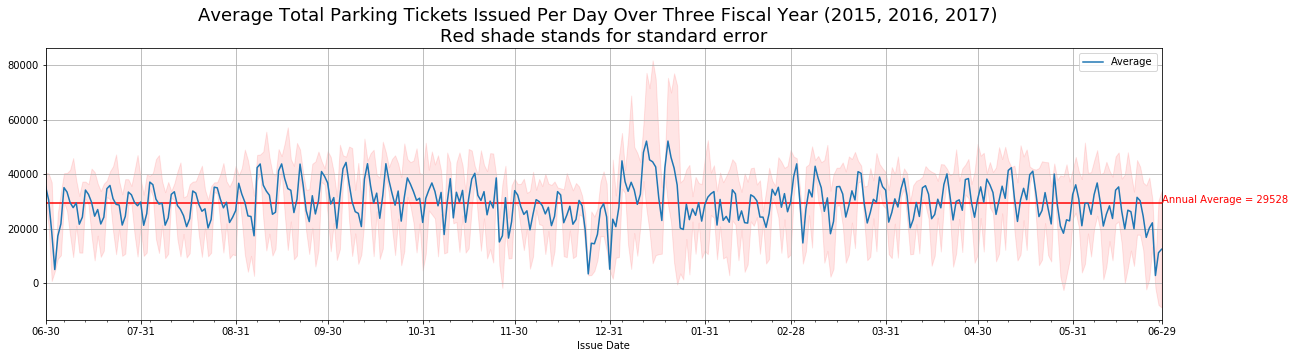

In [188]:
fig2 = plt.figure(figsize = (20,8))
ax2 = fig2.add_subplot(1,1,1)
ax2 = Date_Total_all_years[['Average']].plot(ax = ax2, kind = 'line', figsize = (20,5), alpha = 1, grid = True)
plt.fill_between(Date_Total_all_years.index, Date_Total_all_years['Average+'], Date_Total_all_years['Average-'], alpha = 0.1, color = 'r', label = 'std' )
ax2.hlines(y = Date_Total_all_years['Average'].mean(), xmin = start_dates[0], xmax = end_dates[0], color = 'r')
plt.text(end_dates[0], Date_Total_all_years['Average'].mean(), ("Annual Average = " + str(int(Date_Total_all_years['Average'].mean()))), color = 'r')
plt.title("Average Total Parking Tickets Issued Per Day Over Three Fiscal Year (2015, 2016, 2017)  \nRed shade stands for standard error", fontsize = 18 )
ax2.xaxis.set_major_formatter(dates.DateFormatter('%m-%d'))

After averaged the data gathered for all three years, we can see that:
1. The total tickets issued over the fiscal year since to be very stable, no big changes between months.
2. The number of tickets issued daily seems to fluctuating around the annual average periodically.
3. The small dip within each peak disappears, which indicated they might be just some random fluctuations exist in the individaul dataset.

Now, let's take a deeper look at the distribution of the the daily data in each fiscal year. 

## 2. Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month


As we mentioned before, we are able to see big periodical  fluctution happaning within each month. In addition, we can see that there are roughly four peaks for each month, which matches the number of weeks in a month roughl. So, one hypothesis we could have is that the the total tickets issued matches a certain pattern based on the day of the week. To investigate this, we are going to used violin plots to look at the distribution of the data points based on different weekdays.

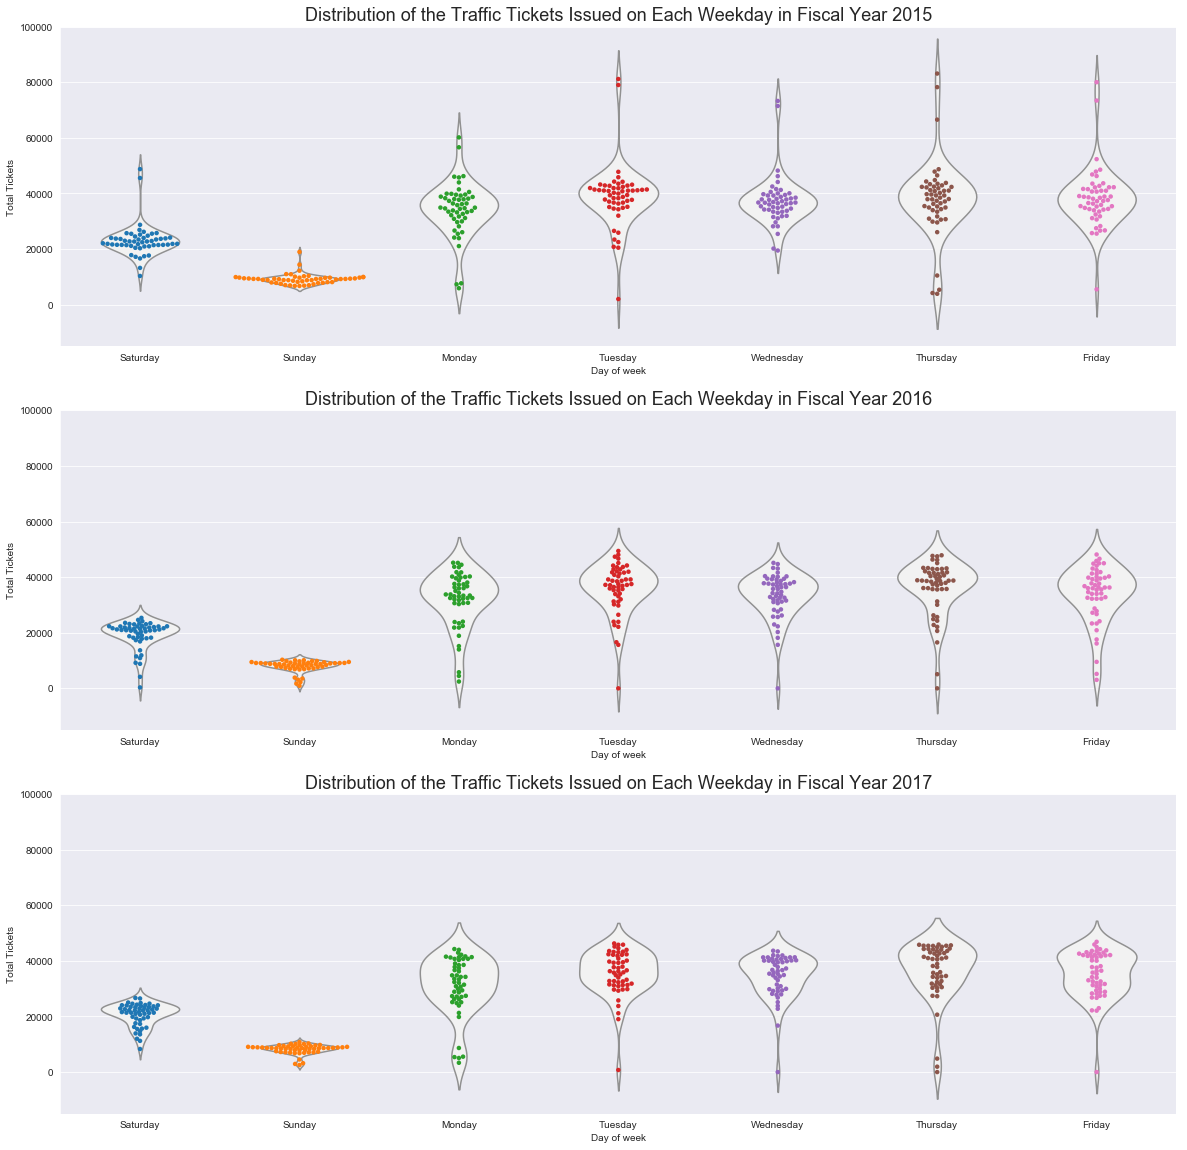

In [298]:
#Violain Plots for individual years by WeekDays
fig4, axes4 = plt.subplots(3,1, figsize = (20,20))
for Date_Total, year, i in zip(Date_Total_list, years, range(3)):  
    Date_Total["Day of week"] = Date_Total.index.day_name()
    #violin plot for the number of tickets gave out on each weekday
    sns.violinplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, height = 2.5, width = 0.5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = 'count', inner = None, color = "0.95")
    sns.swarmplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 4.5)
    axes4[i].set_title('Distribution of the Traffic Tickets Issued on Each Weekday in Fiscal Year ' + str(year), fontsize = 18)    
    axes4[i].set_ylim(-15000, 100000)

From the above violin plots, we can see that from Monday to Friday, the total amount parking tickets issued are on the similar level (~30,000 tickets) for all three fiscal years, except for only a few data points that distributed at the the high end (~80,000 tickets) and low end (~10,000 tickets) On the other hand, the total amount of ticketks issued dropped signficantly on weekends. There are a rougly 50% drop on Saturday, and nearly 75% drop on Sunday when compared with the numbers on weekdays. This is a very reasonable finding while consider that, part of the parking rules in NYC are not enforced on weekends expecially on Sunday (e.g. Pakring meters, or simply we are having less traffic law enforcement officers on duty)

Now we known that Sunday is the day with the lowest number of parking tickets issued, but what about the number of tickets issued at different hours on the same day? Well, let's investigate ;-)

## 3. Total Ticket Issued on Different Hours of the Day

In [211]:
#Function to clean the Violatime input, it will convert '1000P' original entry to a datetime object '1960-01-01-20'. If invalid character
#presents, return -1
def cleanViolationTime(input):
    try:
        h, m, A_P = int(input[0:2]), int(input[2:4]), input[4]
        if A_P not in ['A','P']:
            return -1
        else:
            if A_P == 'P':
                if h == 12:
                    h = 0
                h = (h + 12)
            if A_P == 'A' and h == 12:
                h = 0
            if A_P == 'A': 
                h = h
            return pd.to_datetime("1960-01-01 " + str(h) + ":"+str(m))
    except:
        return -1

In fiscal year 2015 the average number of parking tickets Issued per minute is 8199
In fiscal year 2016 the average number of parking tickets Issued per minute is 7376
In fiscal year 2017 the average number of parking tickets Issued per minute is 7501


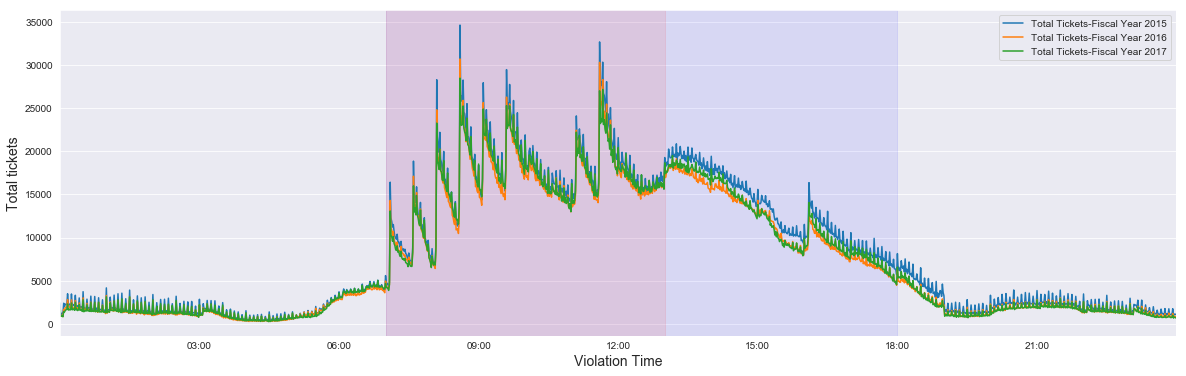

In [306]:
fig5 = plt.figure(figsize = (20,6))
ax = fig5.add_subplot(1,1,1)
for raw_data, year in zip(raw_data_15_17, years):
    #Cleanning the dataset
    hour_data = raw_data[['Violation Time', 'Summons Number']].groupby('Violation Time', as_index = False).count()
    hour_data = hour_data.loc[hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
    hour_data = hour_data.rename(columns = {'Summons Number' : ('Total Tickets-Fiscal Year ' + str(year))})
    hour_data['Cleaned Violation Time'] = hour_data['Violation Time'].apply(cleanViolationTime)
    hour_data = hour_data.loc[hour_data['Cleaned Violation Time'].dt.year == 1960]
    hour_data = hour_data.groupby('Cleaned Violation Time').sum()
    hour_data.plot(ax = ax, kind = 'line', grid = True, alpha = 1)
    ax.set_xlabel("Violation Time", fontsize = 14)
    ax.set_ylabel("Total tickets", fontsize = 14)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    print("In fiscal year", str(year), "the average number of parking tickets Issued per minute is", str(int(hour_data[('Total Tickets-Fiscal Year ' + str(year))].sum()/1440)))
ax.axvspan('1960-01-01 07:00','1960-01-01 18:00', alpha = 0.08, color = 'b' )
ax.axvspan('1960-01-01 07:00','1960-01-01 13:00', alpha = 0.08, color = 'r' )
    

As we can see from above, there are couple very interesting characteristics of this graph that is hard to be overlooked:
1. the majority of the tickets issued are from the 7:00AM to 6:00PM window. (Blue region)
2. From 7:00AM to 1:00PM (Pink area), there seems to have exctly one peak appears in every 30 mins. What is causing those?
3. The plots that generated from three different fiscal years are remarkably similar. Why is that?

To address question 2 and 3, we might have to make some educated guesses here. First, the pattern of the plot from three different years are almost identical. Therefore, I believe it is safe for us to conclude that this pattern is likely caused by something intrinsic of the system rather than by some random variation of the data. we can see that the big peaks are only happend in the morning and each of them are roughly 30 mins apart. Well, this time interval is rather specific. In NYC, the parking rules enforced that could optentially be 30 mins apart... well, one of the possible candidate is our nation-wide famous alternative parking rule. Just by a quick glimpse of the alternative parking map of NYC (NYC ASP Street Parking Map: https://www.freeparknyc.com/), it is not hard to find, that most of the street cleanning time listed are in the window from 7:00 AM to 1:00PM (e.g. 8:30AM-10:00AM and 9:30AM-11:AM). 

Luckly, the dataset we have does contain a specific column for violation codes. Now, let's take a look about how the violation code of the ticket issue is distributed. One of the way to do it is by plotting a heatmap of violation codes and plate types, such that we could have a informative overview regarding, what type of vehicles is breaking what kind of parking rule. Or more specifically, is the number of alternative parking tickets the highest? and what type of vehicle?

## 4. violation codes and Plate Types

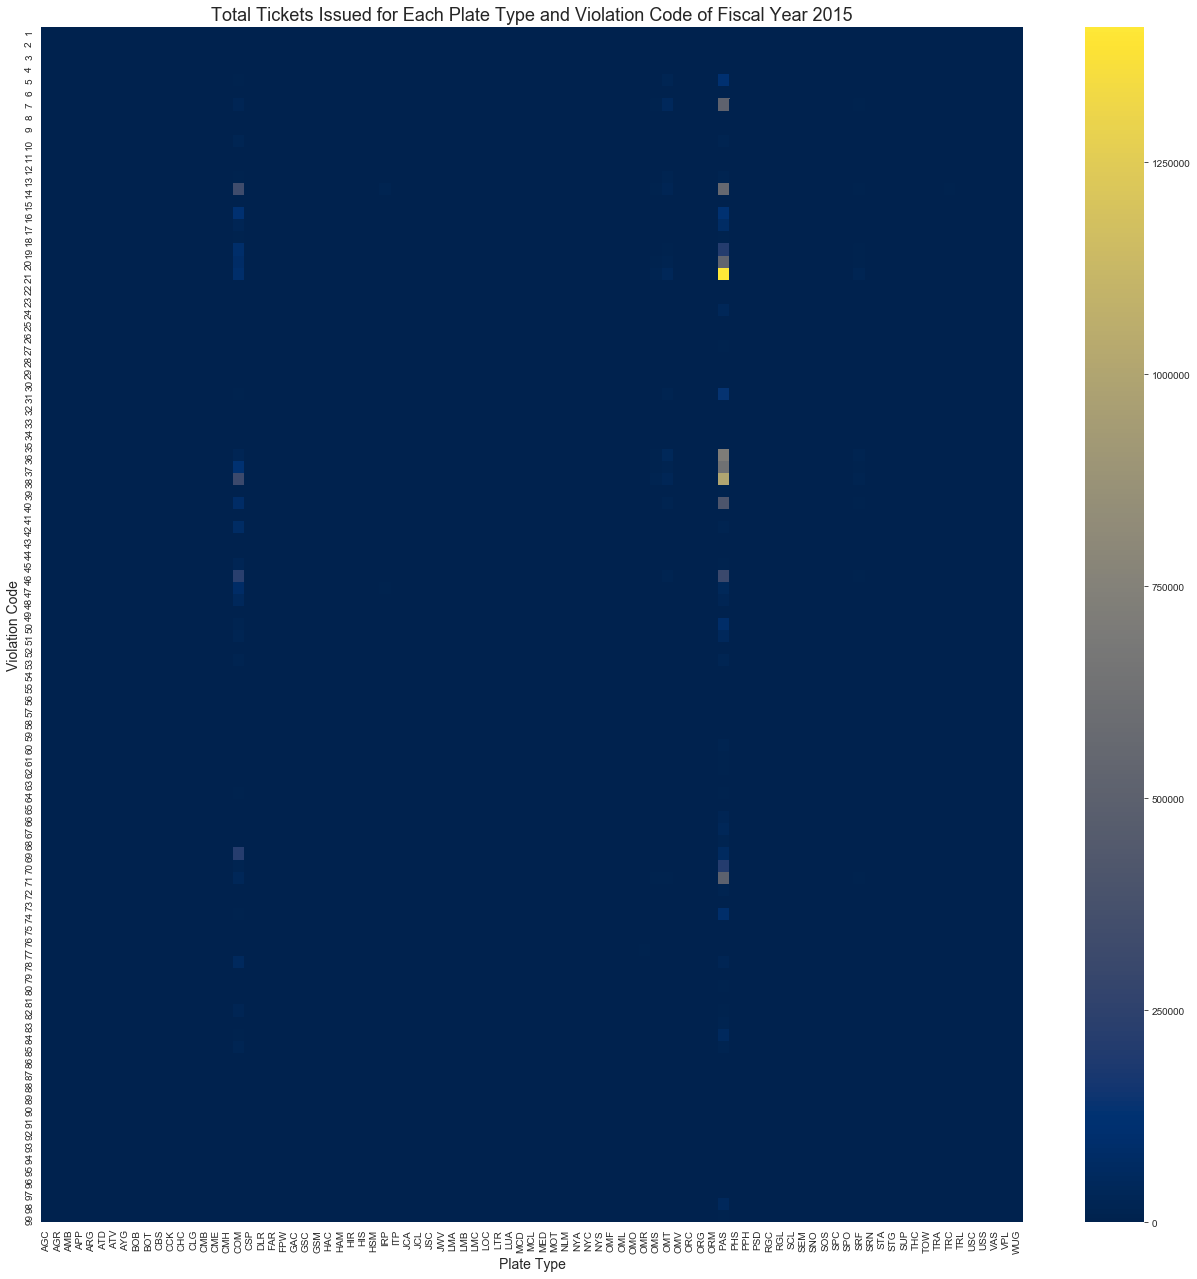

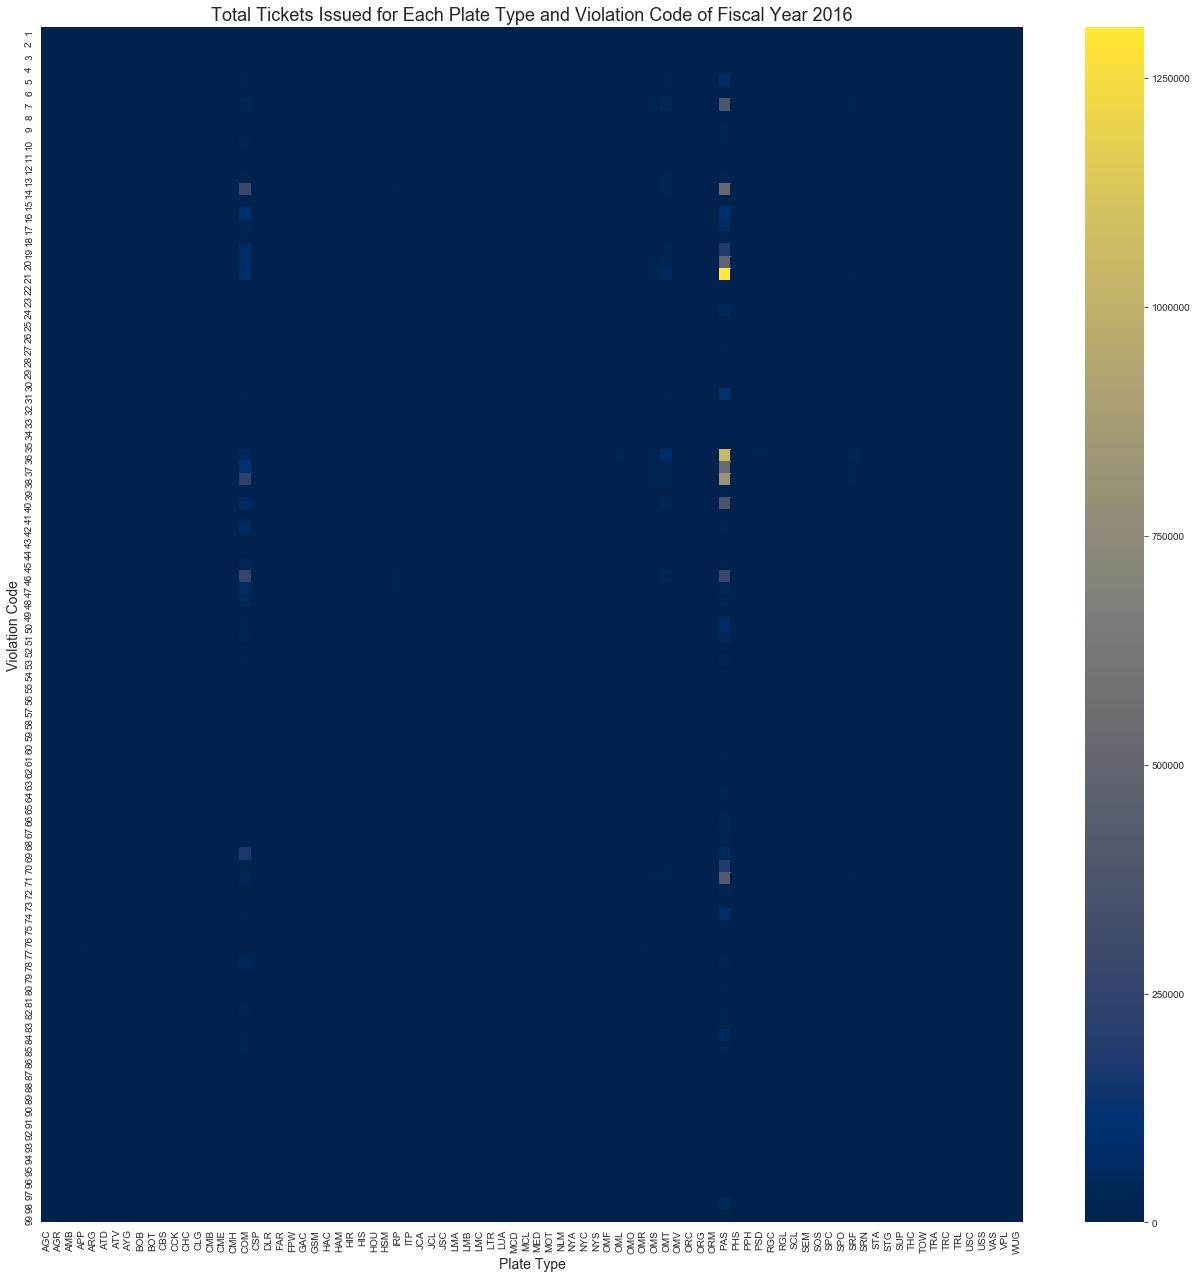

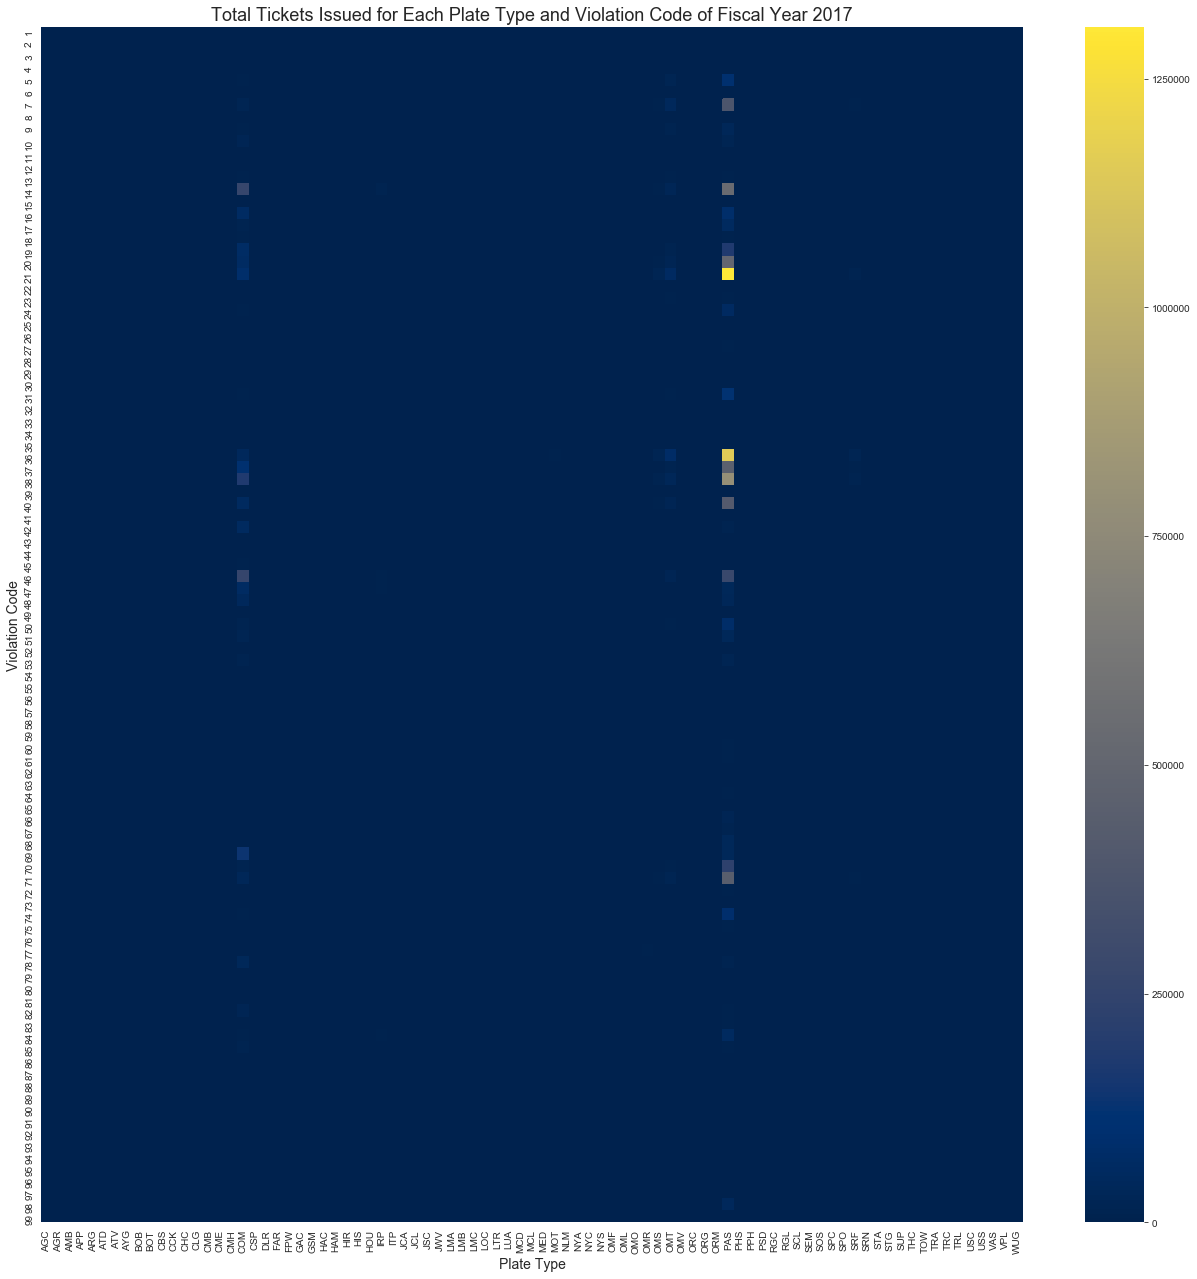

In [297]:
VCode_PT_TotalTX_list = []
for raw_data, start_date, end_date, year in zip(raw_data_15_17, start_dates, end_dates, years): 
    #Create a sub-data set
    Date_VCode_PT_TotalTX = raw_data[['Issue Date','Violation Code','Plate Type','Summons Number']]
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.fillna("not_valid") 
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Issue Date','Plate Type','Violation Code'], as_index = False).count()
    Date_VCode_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_VCode_PT_TotalTX['Issue Date'])
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.set_index('Issue Date')
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[start_date:end_date]
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Plate Type'] != '999']
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Violation Code'] != 0]

    VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Violation Code', 'Plate Type']).sum().reset_index()
    VCode_PT_TotalTX = VCode_PT_TotalTX.fillna(0)
    VCode_PT_TotalTX = VCode_PT_TotalTX.rename(columns = {'Summons Number' : 'Total Tickets'})
    VCode_PT_TotalTX_list.append(VCode_PT_TotalTX)

    #All violation codes and plate type heat plot
    fig, ax = plt.subplots(1,1, figsize = (22,22))
    VCode_PT_TotalTX_all = VCode_PT_TotalTX.pivot(index='Violation Code', columns='Plate Type', values='Total Tickets')
    VCode_PT_TotalTX_all = VCode_PT_TotalTX_all.fillna(0)
    sns.heatmap(ax = ax, data = VCode_PT_TotalTX_all, cmap = "cividis")
    ax.set_title("Total Tickets Issued for Each Plate Type and Violation Code of Fiscal Year " + str(year) ,fontsize = 18)
    ax.set_xlabel("Plate Type", fontsize = 14)
    ax.set_ylabel("Violation Code", fontsize = 14)

From the above three heat maps from three different fiscal years, it is obvious to see that the passenger car almost always have the highest number of tickets issued for most of the violation codes. Since the heat map only gives us a rather qualitative view, we are now going to pick the three violation code that have the brightest dots from the heatmap and investigate further. They are violation code 21, 36, and 38.

## 5. Tickets issued with violation code 21, 36, and 38 

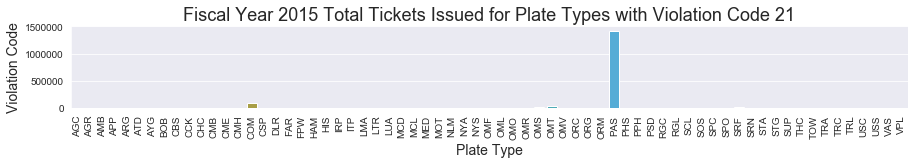

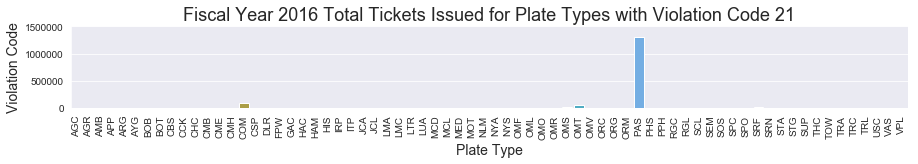

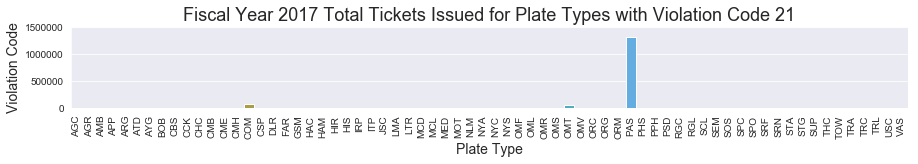

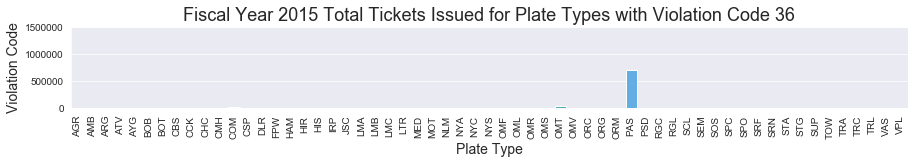

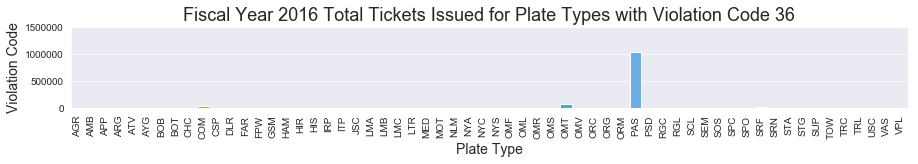

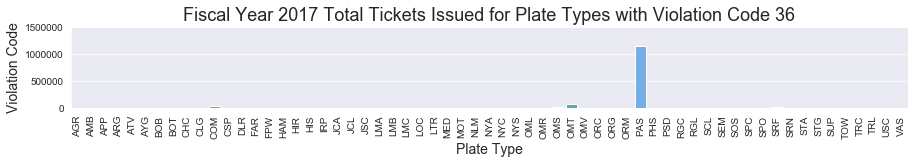

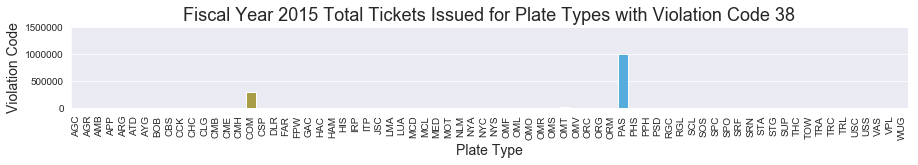

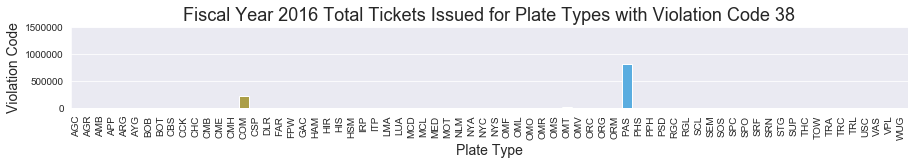

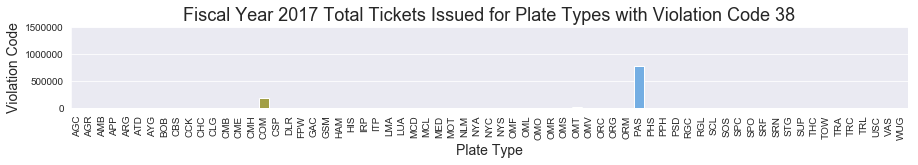

In [296]:
for i in [21,36,38]:
    for VCode_PT_TotalTX, year in zip(VCode_PT_TotalTX_list,years):
    #individual violation code
        selected_df = VCode_PT_TotalTX.loc[VCode_PT_TotalTX['Violation Code'] == i]
        fig8, ax8 = plt.subplots(1,1, figsize = (15,1.5))
        sns.set_style("darkgrid")
        sns.barplot(x = 'Plate Type', y = 'Total Tickets', data = selected_df)
        ax8.set_title("Fiscal Year " + str(year) + " Total Tickets Issued for Plate Types with Violation Code " + str(i) ,fontsize = 18)
        ax8.set_xlabel("Plate Type", fontsize = 14)
        ax8.set_ylabel("Violation Code", fontsize = 14)
        ax8.set_xticklabels(selected_df['Plate Type'], rotation=90, ha = 'center')
        ax8.set_ylim(0, 1500000)
        
        
        

From the above bar graphs, it it easy to see that passenger cars (PAS) is the dominated receiver of the parking tickets with all three violation codes. In additon, violation code 21 has the highest number of ticket issued with it.

But, which one of the three contributed to the weired peaks in the previous graph? It feels like it should be code 21. Well, why don't we just plot them one by one and see how the resulting pattern is like? ;-D

#### 6.  Plate Type = PAS, Violation Code = 21, 36, 38

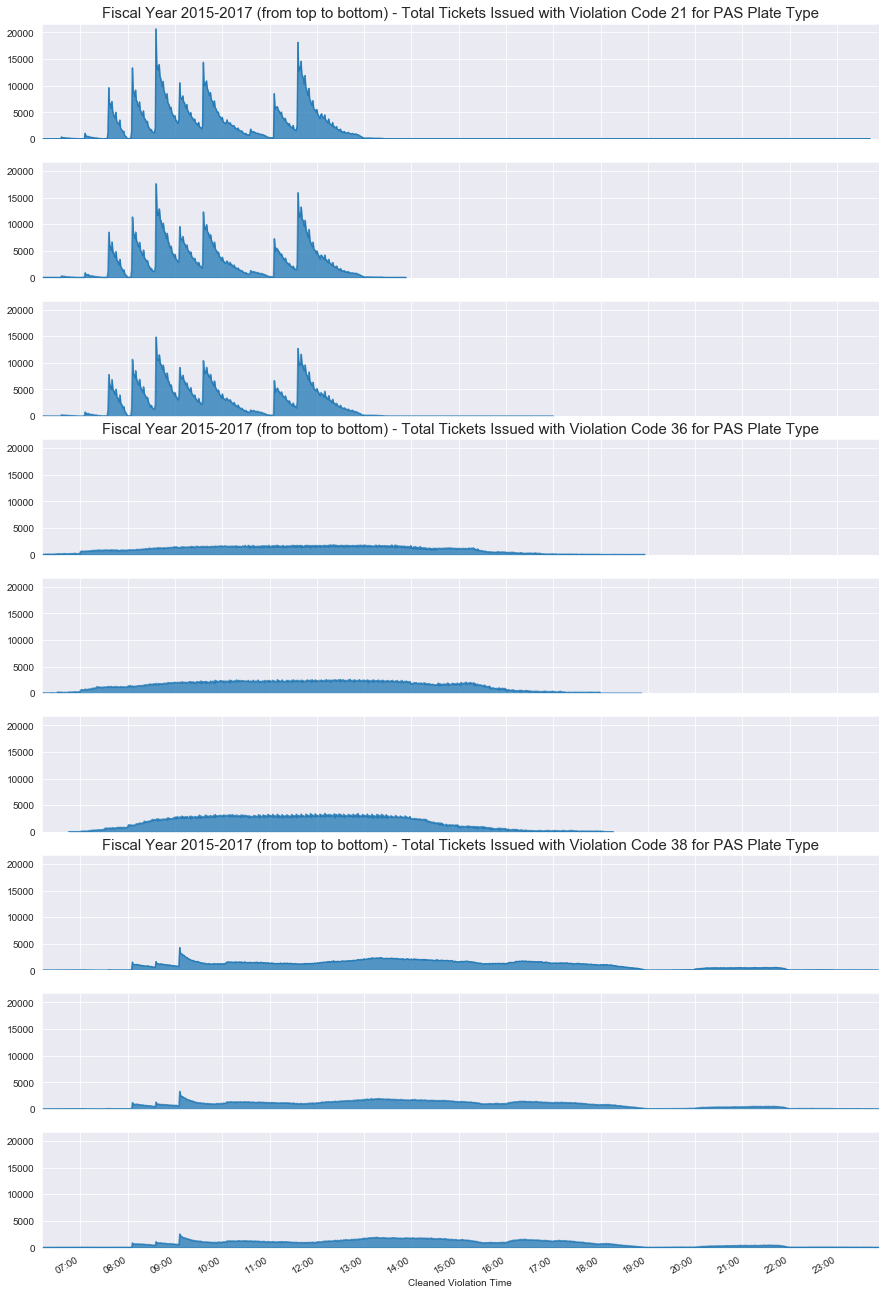

In [322]:
fig, axes = plt.subplots(9,1, sharex = True, sharey = True)
for i,j in zip([21,36,38],[0,3,6]):   
    for raw_data, year, k in zip(raw_data_15_17,years, range(3)):
        PAS_hour_data = raw_data[['Violation Time', 'Summons Number', 'Violation Code', 'Plate Type']]
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Plate Type'] == 'PAS']
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Violation Code'] == i]
        PAS_hour_data = PAS_hour_data.groupby('Violation Time', as_index = False).count()
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
        PAS_hour_data = PAS_hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
        PAS_hour_data['Cleaned Violation Time'] = PAS_hour_data['Violation Time'].apply(cleanViolationTime)
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Cleaned Violation Time'].dt.year == 1960]
        PAS_hour_data = PAS_hour_data.groupby('Cleaned Violation Time').sum()
        PAS_hour_data['Total Tickets'].plot(ax = axes[k+j], figsize = (15,25), grid = True, kind = 'area', alpha = 0.75)
        axes[k+j].xaxis.set_major_locator(dates.HourLocator())
        axes[k+j].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
        if k == 0:
            axes[k+j].set_title("Fiscal Year 2015-2017 (from top to bottom) - Total Tickets Issued with Violation Code " + str(i) + ' for PAS Plate Type' ,fontsize = 15)


From the figures above, it looks like that tickets issued with violation code 21 is very possible the major contributor of the big peaks with 30mins interval in the previous graph from section 3, becuase the pattern at the time window from 7:00AM to 1:00PM looks very similar to the one from section 3.

Now, let's take a look at which area of NYC gets the most parking tickets every fiscal year.

## 7. Total Tickets Issued by Each Precinct of NYC 

To generate a NYC map with the number of tickets issued, we need the columns that contains the geographic information from the dataset, and also, the column must not have too many missing entries such that it is fairly represnetative relative to the total tickets number we calculated. After compare all columns contains the geographic information, I decided to pick the 'violation precinct' column since it fits the above requirment.

The shapefile I used for the NYC precinct map could be found here:
https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz

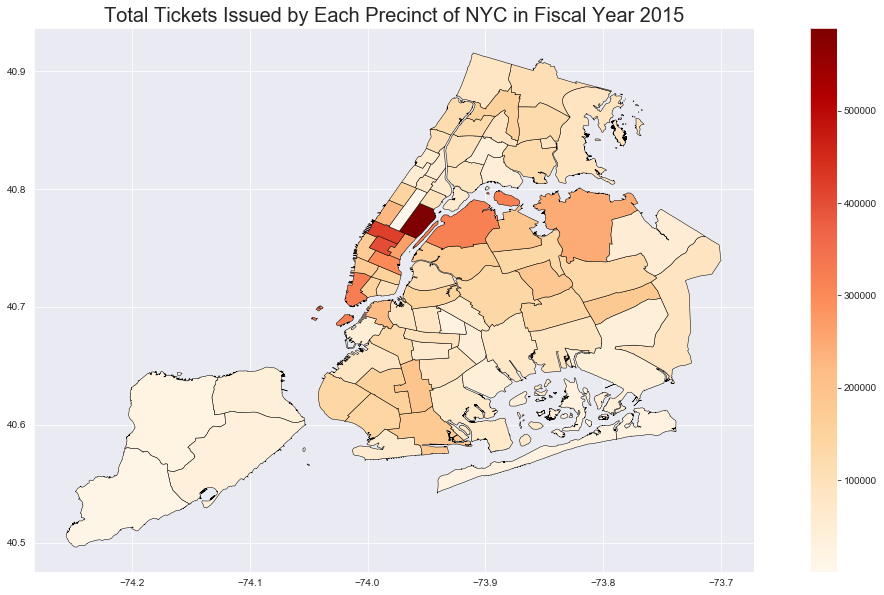

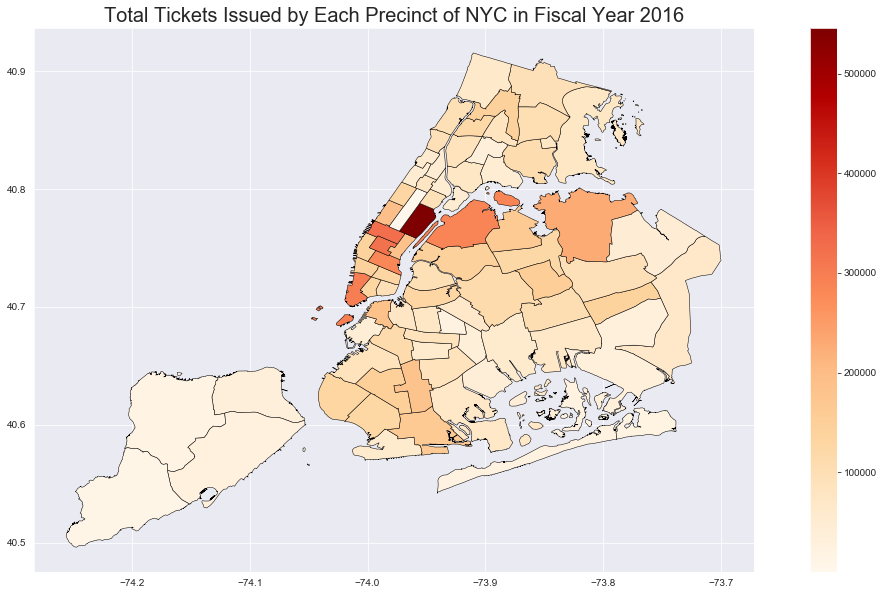

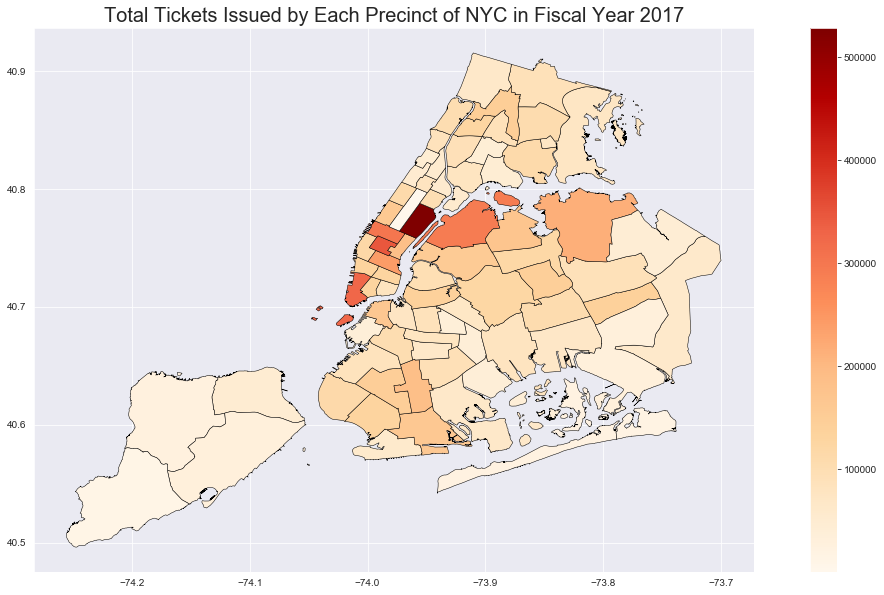

In [528]:
for raw_data, start_date, end_date, year in zip(raw_data_15_17, start_dates, end_dates, years):   
    Date_Precinct_TotalTX = raw_data[['Issue Date','Violation Precinct','Summons Number']]
    #Group data based on issue date and precinct
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.groupby(['Issue Date','Violation Precinct'], as_index = False).count()
    Date_Precinct_TotalTX['Issue Date'] = pd.to_datetime(Date_Precinct_TotalTX['Issue Date'])
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.set_index('Issue Date')
    #locate data within the approporiate fiscal year range
    Date_Precinct_TotalTX = Date_Precinct_TotalTX[start_date:end_date]
    #Group data base on precinct
    Precinct_TotalTX = Date_Precinct_TotalTX.groupby('Violation Precinct').sum()
    #remove invalid precinct entries
    Precinct_TotalTX = Precinct_TotalTX[1:124]
    Precinct_TotalTX = Precinct_TotalTX.drop([2,3,4,8,11,12,15,16,21,27,29,31,35,36,37,38,39,51,53,54,55,56,57,58,59,64,65,74,80,82,85,86,87,89,91,92,93,95,96,97,98,99,116,117,118,119])

    #Precinct Heat Map
    map_path = "./precinct_map/geo_export_1ac7dc26-ca74-4ae0-8bef-28d6099c5e96.shp"
    data = gpd.read_file(map_path)
    data = data.set_index('precinct')
    data = pd.concat([data,Precinct_TotalTX], axis = 1)
    fig, ax = plt.subplots(1, 1, figsize = (20,10))
    data.plot(column='Summons Number', legend=True, ax = ax, cmap = 'OrRd',linewidth = 0.5, edgecolor = 'k')
    ax.set_title("Total Tickets Issued by Each Precinct of NYC in Fiscal Year " + str(year), Fontsize = 20)
    
    